### Import stuff

In [1]:
import os
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, ReLU
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
import scipy.stats

2023-08-16 15:03:30.049156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
rm -rf ./logs/

### Sorting data

In [11]:
files = ['KKSM01.root']

for filename in files:
    print("Processing file " + filename)
    
    with uproot.open(filename) as file:
        
        trkana = file['TAKK']["trkana"].arrays(filter_name="/de|detsh|detshmc|demc/i")
        trkana = trkana[(trkana['de.goodfit']==1)&(trkana['de.status']>0)&(trkana['demc.proc']==167)]
        
        # hit time
        htime = ak.concatenate(trkana['detsh.htime']).to_numpy()
        # estimated energy deposited
        edep = ak.concatenate(trkana['detsh.edep']).to_numpy()
        # estimated drift time using 'time over total' threshold
        totdrift = ak.concatenate(trkana['detsh.totdrift']).to_numpy()
        # monte-carlo sim
        t0 = []
        dist = []
        
        for i, this_dt in enumerate(trkana['detsh.state']):
            t0.extend(trkana['detshmc.t0'][i][:len(this_dt)])
            dist.extend(trkana['detshmc.dist'][i][:len(this_dt)])
        # transform to numpy array
        t0 = np.array(t0)
        dist = np.array(dist)
        # drift time
        tdrift = htime - t0
        # cutting or slicing?
        dist = dist[tdrift<100]
        totdrift = totdrift[tdrift<100]
        edep = edep[tdrift<100]
        tdrift = tdrift[tdrift<100]
        

Processing file KKSM01.root


In [12]:
# tdrift = tdrift[:, np.newaxis] # add one column
# totdrift = totdrift[:, np.newaxis]
# edep = edep[:, np.newaxis]

input_var = np.vstack((tdrift, totdrift, edep)).T
print(input_var.shape)

(393835, 3)


In [10]:
print(tdrift.shape)
print(totdrift.shape)
print(edep.shape)

(393835, 1)
(393835, 1)
(393835, 1)


In [13]:
bsize = 32

n_variables = input_var.shape[1]

x_ce_train, x_ce_test, y_ce_train, y_ce_test = train_test_split(input_var, dist, test_size=0.5, 
                                                                random_state=42)
x_ce_test, x_ce_valid, y_ce_test, y_ce_valid = train_test_split(x_ce_test, y_ce_test, test_size=0.5, random_state=42)

# Multi-Layer Perceptron

Refer to TrainBkg for info

In [22]:
# load previous training if it exists
modelfile = "models/TrainBkg" + ".h5"
if os.path.isfile(modelfile):
    model = keras.models.load_model(modelfile)
    print("Loading model from file " +modelfile)
else:
    print("Creating model " +modelfile)
    lay0=Input(shape=(n_variables), batch_size=bsize)
    lay1=Dense(2*n_variables, activation='relu')(lay0)
    lay2=Dense(2*n_variables, activation='relu')(lay1)
    lay3=Dense(2*n_variables, activation='relu')(lay2)
#     lay4=Dense(1,activation='sigmoid')(lay3)
    lay4=Dense(1)(lay3)
    model=Model(inputs=lay0,outputs=lay4)

opt = Adam(learning_rate=1e-4)
model.compile(loss='mean_absolute_error',metrics='accuracy',optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=20, min_delta=1e-5, restore_best_weights=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(x_ce_train, y_ce_train,
                          batch_size=bsize,
                          epochs=10,
                          verbose=1,
                          validation_data=(x_ce_valid, y_ce_valid),
                          callbacks=[early_stop, tensorboard_callback]
                         )

Creating model models/TrainBkg.h5
Epoch 1/10
6154/6154 [==============================] - 6s 860us/step - loss: 0.6299 - accuracy: 0.0000e+00 - val_loss: 0.1518 - val_accuracy: 0.0000e+00
Epoch 2/10
6154/6154 [==============================] - 5s 821us/step - loss: 0.1511 - accuracy: 0.0000e+00 - val_loss: 0.1532 - val_accuracy: 0.0000e+00
Epoch 3/10
6154/6154 [==============================] - 5s 821us/step - loss: 0.1507 - accuracy: 0.0000e+00 - val_loss: 0.1511 - val_accuracy: 0.0000e+00
Epoch 4/10
6154/6154 [==============================] - 5s 824us/step - loss: 0.1505 - accuracy: 0.0000e+00 - val_loss: 0.1508 - val_accuracy: 0.0000e+00
Epoch 5/10
6154/6154 [==============================] - 5s 821us/step - loss: 0.1504 - accuracy: 0.0000e+00 - val_loss: 0.1524 - val_accuracy: 0.0000e+00
Epoch 6/10
6154/6154 [==============================] - 5s 831us/step - loss: 0.1504 - accuracy: 0.0000e+00 - val_loss: 0.1516 - val_accuracy: 0.0000e+00
Epoch 7/10
6154/6154 [====================

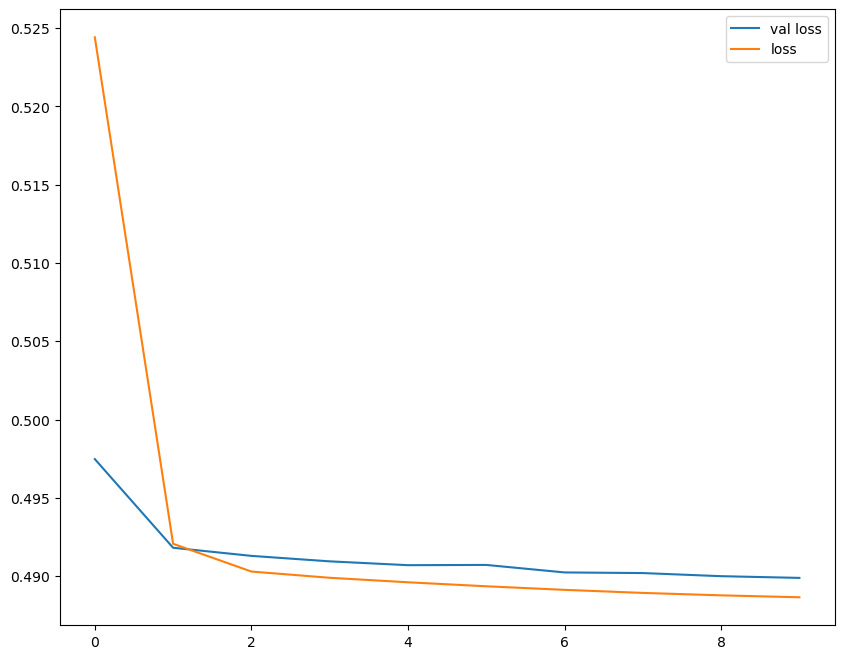

In [16]:
plt.figure(figsize=(10,8))
plt.plot(history.history['val_loss'],label="val loss")
plt.plot(history.history['loss'],label="loss")
plt.legend()
plt.show()

# Linear Regression

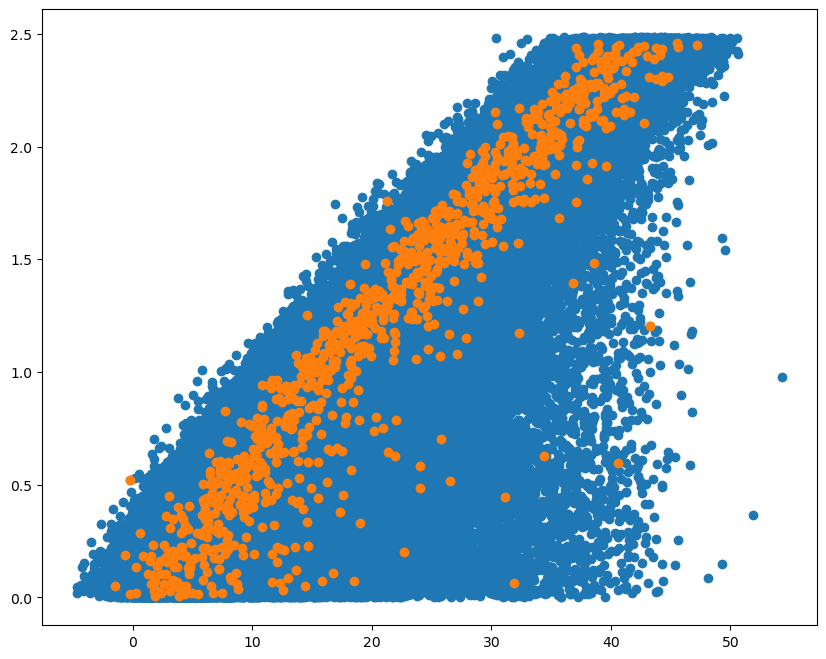

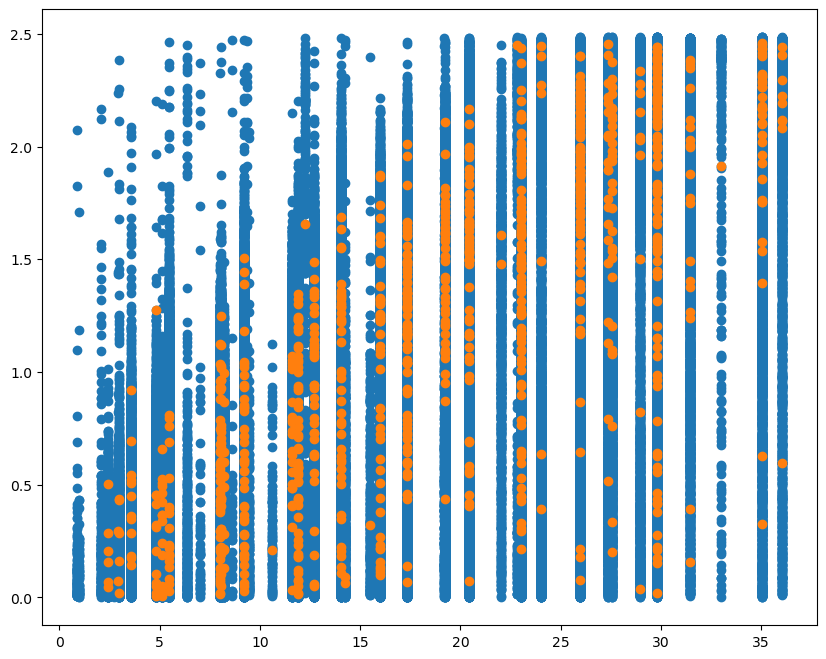

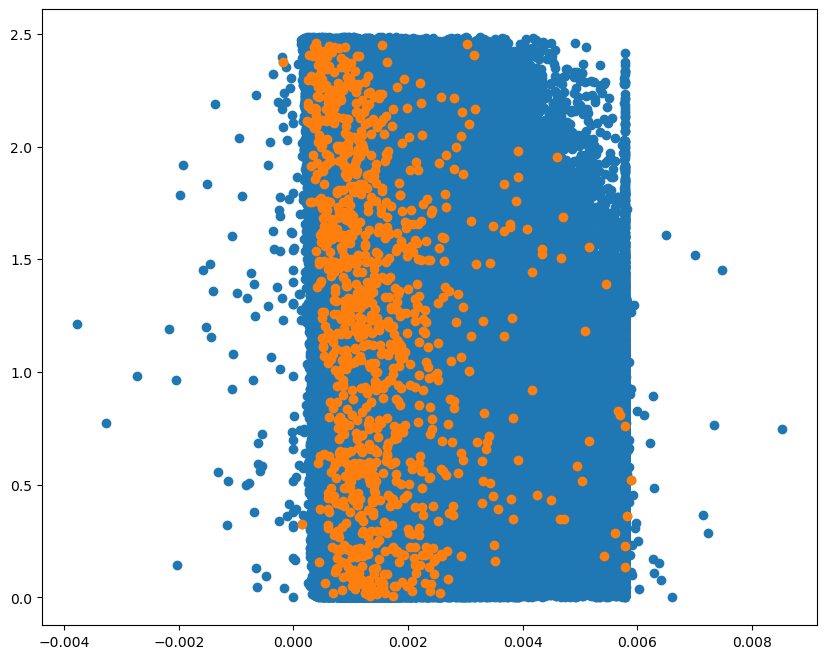

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(tdrift,dist)
plt.scatter(tdrift[:1000], dist[:1000])
plt.show()

plt.figure(figsize=(10,8))
plt.scatter(totdrift,dist)
plt.scatter(totdrift[:1000], dist[:1000])
plt.show()

plt.figure(figsize=(10,8))
plt.scatter(edep,dist)
plt.scatter(edep[:1000], dist[:1000])
plt.show()

In [ ]:
tdrift_input = tf.linspace(-10, 50, 1000)
dist_predict0 = model.predict(tdrift_input)

plt.figure(figsize=(10,8))
plt.scatter(tdrift[:1000], dist[:1000])
plt.plot(tdrift_input, dist_predict0, 'r-')
plt.show()

12308/12308 [==============================] - 4s 347us/step


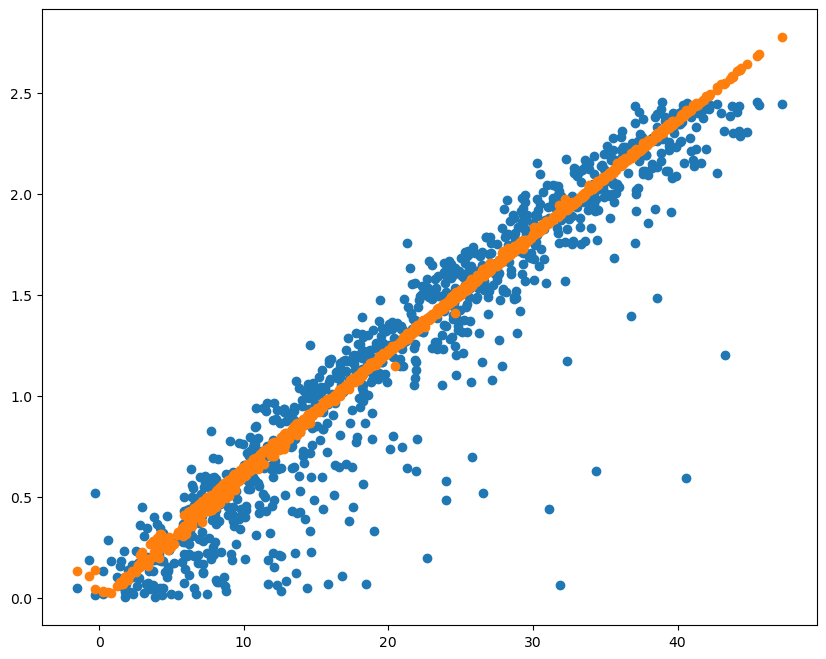

In [23]:
dist_predict1 = model.predict(input_var)[:1000,0]

plt.figure(figsize=(10,8))
plt.scatter(tdrift[:1000], dist[:1000])
plt.scatter(tdrift[:1000], dist_predict1[:1000])
plt.show()

In [26]:
# tdrift_input = tf.linspace(-10, 50, 1000)
# dist_predict0 = model.predict(tdrift_input)

dist_predict1 = model.predict(input_var)[:,0]

# plt.figure(figsize=(10,8))
# plt.scatter(tdrift, dist, label='unsliced')
# plt.scatter(tdrift[:1000], dist[:1000], label='sliced')
# plt.plot(tdrift_input, dist_predict0, 'r-',label='sliced')
# plt.plot(tdrift, dist_predict1, 'g-',label='unsliced')
# plt.legend()
# plt.show()

12308/12308 [==============================] - 4s 352us/step


# Residual

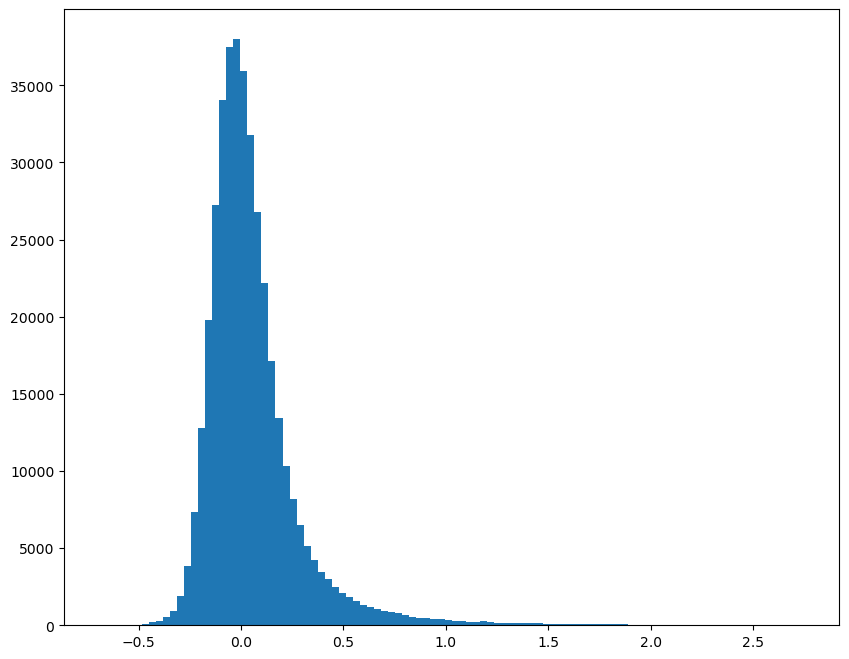

In [27]:
residual = dist_predict1 - dist
plt.figure(figsize=(10,8))
plt.hist(residual, bins=100)
plt.show()

Rms is 0.2359003


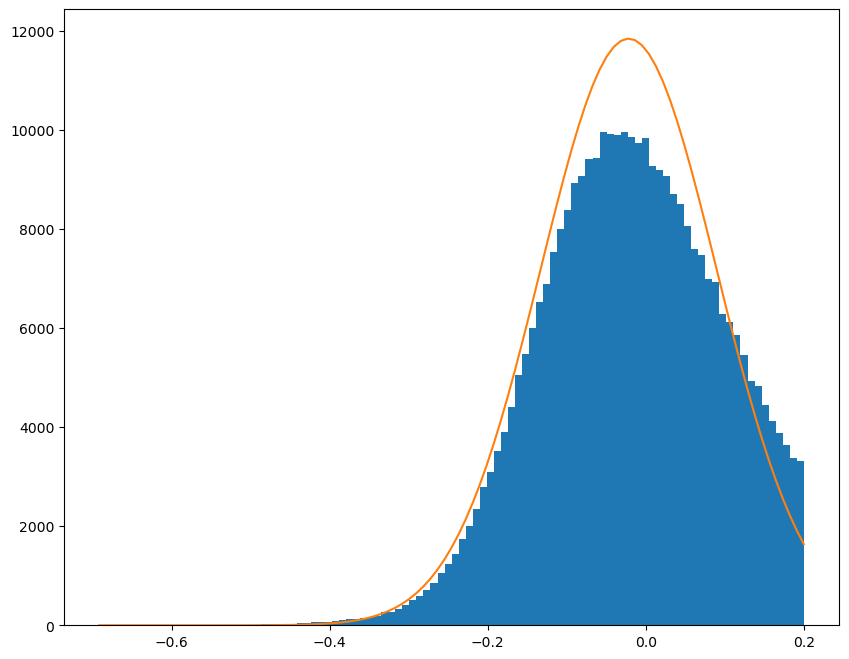

Sigma is 0.11143961


In [28]:
rms = np.std(residual)
print('Rms is', rms)

plt.figure(figsize=(10,8))
_, bins, _ = plt.hist(residual[residual<0.2], bins=100)
mu, sigma = scipy.stats.norm.fit(residual[residual<0.2])
fit = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins,fit*len(residual[residual<0.2])/100)
plt.show()
print('Sigma is', sigma)